# 42186 - Model-based Machine Learning
## Exam project: Predicting Day-Ahead Electricity Prices in the Nordic

**Group members**: 
- Søren Blatt Bandtsen (s164521) 
- Julius Lindberg Steensberg (s193885) 
- Frederik Vejby Nielsen (s183709) 
- Søren Nielsen Sardemann (s193893)

## Introduction

The price of electricity is established on the day-ahead market, where the price is set at 12:00 noon the day before for the 24 hours of the following day. This means that after 12:00, the prices for the next day are known. These day-ahead prices (DA prices) are set for each bidding zone. In Denmark, there are two bidding zones, whereas Norway, for instance, has five bidding zones. The bidding zones are connected by transmission lines, which allows for trade between the bidding zones, limited by their capacity. This makes the Nordic system a highly interconnected system and the DA prices are therefore correlated. Bidding zones have equal DA prices if the transmission is not congested since the marginal producer in the most expensive bidding zone also becomes the marginal producer in the region to which power is exported, as long as there is sufficient transmission capacity.

Also, the DA price for each bidding zone is influenced by the demand for electricity at the given hour for the bidding zone, the supply of renewable power generation (wind, solar, etc.), and conventional power generation, but also by the production and consumption in the neighboring bidding zones (even neighbors' neighbors) due to the interconnectivity and trade between bidding zones.

The goal of this project is to model all of these dynamics in order to provide the best prediction possible of the DA prices in the Nordic bidding zones. To simplify things a bit, the primary focus will be on forecasting the DA prices of DK1 (covering Jutland and Funen), leading to the following research question:

*What factors influence the day-ahead prices in DK1, and how can these dynamics be accurately modeled to predict the DA-prices using model-based machine learning techniques?*

# Import relevant libraries

In [10]:
# Import libraries
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Numpyro libraries
import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

# JAX
import jax
import jax.numpy as jnp 
from jax import random, vmap
from jax.scipy.special import logsumexp 
from jax import lax 

# Personalized function library
from prepare_country_data import transpose_for_country_code, split_and_normalize, cyclical_transformation
plt.style.use('ggplot') # use ggplot styling

# The dataset

The data used in this project has been obtained from ENTSO-E (European Network of Transmission System Operatores for Electricity), who has a publicly available API for querying data. The complete script for querying data can be found in **INSERT FILENAME**.
The complete dataset is stored in the file `nordic_energy_data.csv`, which contains the following parameters for each of the 12 Nordic bidding zones:
- UTC Timestamp
- Day Ahead Price
- Wind Offshore
- Wind Onshore
- Solar
- Total Generation
- Forecasted load
- Capacity To...

The downloaded dataset contains data for the year 2023.

In [36]:
# Load complete dataset
df = pd.read_csv("data/2023/nordic_energy_data.csv") # Load ENTSO-E data

# NB! Due to the sheer size of the dataset and the time it takes to download, 
# the data is downloaded in another script and saved to a .csv file.

## Prepare dataset

The dataset has the data for each bidding zone following each other. Thus, the function `transpose_for_country_code` picks out data for only one bidding zone (here "DK_1"). The relevant data for the other bidding zones are then appended as additional columns. 
Afterwards, `cyclical_transformation` uses the timestamp to add extra columns to capture any dependence on day of the month or hour of day, by taking the cosine and sine of the day and hour.
Using sklearn, the dataset is split into a training set, comprising the first 11 months of the year, and a test dataset comprising the final month of 2023 i.e. December.

In [5]:
# Transpose and filter data for DK1
df_dk1 = transpose_for_country_code(df, "DK_1")
# Apply cyclical transformation to time
df_dk1 = cyclical_transformation(df_dk1)
df_dk1['Timestamp'] = pd.to_datetime(df_dk1['Timestamp']) # Convert to datetime

# Define number of test days
test_days = 31
# Apply split and normalization based on desired number of test days
X_train, X_test, y_train, y_test, X_train_mean, X_train_std, y_train_mean, y_train_std = split_and_normalize(df_dk1, test_days=test_days)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

# Convert to numpy arrays - relevant for some models
X_train_num = X_train.to_numpy()
X_test_num = X_test.to_numpy()
y_train_num = y_train.to_numpy()
y_test_num = y_test.to_numpy()



X_train shape: (7992, 92)
X_test shape: (744, 92)
y_train shape: (7992,)
y_test shape: (744,)


## Data description & visualization

In [38]:
print("Dataset size:", len(df))
print("General statistics:")
df.describe()

Dataset size: 105071
General statistics:


Unnamed: 0  DA-price [EUR/MWh]  Forecasted Load    Actual Load  \
count  105071.000000       105071.000000    105071.000000  105059.000000   
mean    52535.000000           58.567777      3618.008128    3601.679818   
std     30331.529404           46.473230      2795.172524    2814.183082   
min         0.000000         -500.000000       921.000000     270.000000   
25%     26267.500000           21.180000      1799.000000    1769.000000   
50%     52535.000000           50.950000      2545.000000    2541.000000   
75%     78802.500000           90.830000      3983.000000    4032.000000   
max    105070.000000          777.180000     15255.000000   16155.000000   

       Forecasted Generation          Solar  Wind Offshore   Wind Onshore  \
count          105071.000000  105071.000000   17424.000000  105071.000000   
mean             3981.547573      46.557166     458.974001     694.800268   
std              2710.644299     149.217444     312.282085     827.453708   
min               112.000000       0.000000       0.000000       0.000000   
25%              1942.000000       0.000000     181.000000     115.000000   
50%              3127.000000       0.000000     414.000000     393.000000   
75%              5741.000000       2.000000     732.000000     987.000000   
max             13101.000000    1828.000000    1141.000000    7017.000000   

         Ex_to_DE_LU     Ex_to_DK_1  ...    Cap_to_NO_2    Cap_to_NO_3  \
count  105071.000000  105071.000000  ...  105071.000000  105071.000000   
mean      222.008661     103.036908  ...     336.740528     236.137469   
std       495.682913     305.093986  ...     669.193548     382.053206   
min         0.000000       0.000000  ...       0.000000       0.000000   
25%         0.000000       0.000000  ...       0.000000       0.000000   
50%         0.000000       0.000000  ...       0.000000       0.000000   
75%         0.000000       0.000000  ...       0.000000     500.000000   
max      2500.000000    1730.000000  ...    2200.000000    1200.000000   

         Cap_to_NO_4    Cap_to_NO_5      Cap_to_PL      Cap_to_RU  \
count  105071.000000  105071.000000  105071.000000  105071.000000   
mean       96.848797     138.786154      47.122422      18.419545   
std       183.770422     259.237352     160.949390      74.532058   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max       600.000000     800.000000     600.000000     320.000000   

         Cap_to_SE_1    Cap_to_SE_2    Cap_to_SE_3    Cap_to_SE_4  
count  105071.000000  105071.000000  105071.000000  105071.000000  
mean      404.935234     919.056638     996.527491     529.270684  
std       927.113265    2091.899701    1832.799853    1399.362331  
min         0.000000       0.000000       0.000000       0.000000  
25%         0.000000       0.000000       0.000000       0.000000  
50%         0.000000       0.000000       0.000000       0.000000  
75%         0.000000     250.000000    1200.000000       0.000000  
max      3300.000000    7300.000000    7300.000000    6200.000000  

[8 rows x 63 columns]

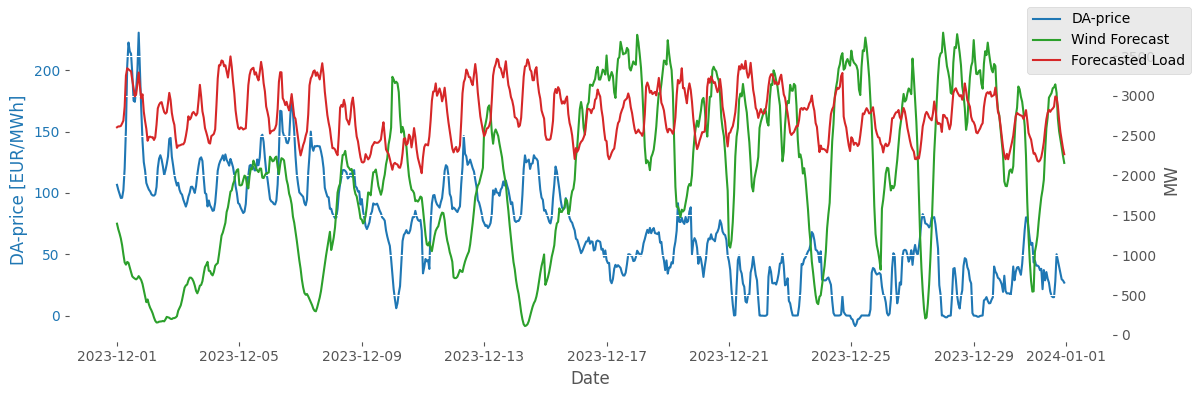

In [39]:
#plot electricity prices for DK1 in december 2023
df_dk1_december = df_dk1[df_dk1.index.month == 12]

fig, ax1 = plt.subplots(figsize=(12, 4))

# Plot the DA-price on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('DA-price [EUR/MWh]', color=color)
ax1.plot(df_dk1_december.index, df_dk1_december['DA-price [EUR/MWh]'], label='DA-price', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

# Create a secondary y-axis for the wind data
ax2 = ax1.twinx()  
color = 'tab:green'
ax2.set_ylabel('MW')
ax2.plot(df_dk1_december.index, df_dk1_december['Wind Onshore'] + df_dk1_december['Wind Offshore'], label='Wind Forecast', color=color)
ax2.plot(df_dk1_december.index, df_dk1_december['Forecasted Load'], label='Forecasted Load', color='tab:red')
ax2.tick_params(axis='y')

# Add a title and legend
#fig.suptitle('Electricity Price, wind forecast and load forecast for DK1 in December 2023')
fig.legend(loc='upper right')
fig.patch.set_facecolor('white')
ax1.set_facecolor('white')

fig.tight_layout()  # To ensure there's no overlap
#save fig in plots folder
plt.savefig('plots/DA-price_wind_forecast_load_forecast_december_2023.png', bbox_inches='tight')
# Display the plot
plt.show()

# State-space models
The following section presents two modelling approaches based on state-space models. One is a univariate linear dynamical system for predicting the day-ahead price in one bidding zone, while the other is a multivariate version of the same model for multiple, connected bidding zones. 

## Univariate linear dynamical system (LDS) with inputs


The simplest model is a linear dynamical system for one bidding zone, which can be described by the probabilistic graphical model shown below. A linear dynamical system is a sub-class of state-space models where we assume linear Gaussian distributions for the transmission and emission probabilities. 

![PGM for the Univariate LDS](PGM_Univariate.png)

In [7]:
T = len(y_train)
T_forecast = len(y_test)

# Remove first two input values since we use an AR(2) model
x = pd.concat([X_train[2:], X_test]).to_numpy()
x = x[:,:5] # only use first 5 parameters 
y = y_train.to_numpy()

N,D = x.shape

ix_obs = np.arange(T)

y_true_std = y_train_std
y_true_mean = y_train_mean

print("T=%d" % T)
print("T_forecast=%d" % T_forecast)
print("N=%d, D=%d" % (N,D))



T=7992
T_forecast=744
N=8734, D=5


Here we define the function for the latent state, which is used in `jax.lax.scan` to propagate the dynamics and speed up the model.

In [8]:
def f(carry, input_t):
    # carry contains:
    #   B       : sampled from a prior
    #   W       : sampled from prior i guess
    #   h_prev  : the previous value
    #   tau     : parameter for parametrization of noise
    beta1, beta2, W, h_prev1, h_prev2, tau = carry
    # inputs are:
    #   noise_t : noise at time stamp t
    #   x_t     : input weather data at time stamp t
    x_t, noise_t = input_t
    # Calculation
    h_t = beta1*h_prev1 + beta2*h_prev2 + jnp.matmul(W, x_t) + tau*noise_t
    h_prev2 = h_prev1
    h_prev1 = h_t
    
    return (beta1,beta2, W, h_prev1,h_prev2, tau), h_t

**Defining the model**

In [11]:
def model(T, T_forecast, x_t, obs=None, ix_mis=None, ix_obs=None):
    # Define priors over B, R, W, c
    beta1 = numpyro.sample("beta1", dist.Normal(loc=0., scale=1.))
    beta2 = numpyro.sample("beta2", dist.Normal(loc=0., scale=1.))
    W = numpyro.sample("W", dist.Normal(loc=jnp.zeros(D), scale=jnp.ones(D)))

    tau = numpyro.sample("tau", dist.HalfCauchy(scale=.1))

    sigma = numpyro.sample("sigma", dist.HalfCauchy(scale=.1))

    h_prev1 = numpyro.sample("z_1", dist.Normal(loc=0., scale=.1))
    h_prev2 = numpyro.sample("z_2", dist.Normal(loc=0., scale=.1))

    noises_t = numpyro.sample("noises_t", dist.Normal(0., 1.), sample_shape=(T+T_forecast-2,))

    # Propagate the dynamics using jax.lax.scan
    carry = (beta1, beta2, W, h_prev1, h_prev2, tau)
    input_t = (x_t, noises_t)
    h_collection = [h_prev1, h_prev2]
    carry, hs_exp = lax.scan(f, carry, input_t, T+T_forecast-2)
    h_collection = jnp.concatenate((jnp.array(h_collection), hs_exp), axis=0)

    # Sample observed and missing values
    #numpyro.sample(name="y_mis", fn=dist.Normal(loc=z_collection[ix_mis], scale=sigma), obs=None)
    numpyro.sample("y_mis", dist.Normal(loc=h_collection[ix_mis], scale=sigma), obs=None)
    numpyro.sample("y_obs", dist.Normal(loc=h_collection[ix_obs], scale=sigma), obs=obs[ix_obs])
    numpyro.sample("y_pred", dist.Normal(loc=h_collection[T:], scale=sigma), obs=None)
    return h_collection

The MCMC inference is run over 1,000 samples in 2 chains. Since the dynamics seem quite complex, we want to ensure as best as possible that the latent variables are thoroughly investigated.

In [13]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
nuts_kernel = NUTS(model=model)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, num_chains=2)
mcmc.run(rng_key_, T=T, T_forecast=T_forecast, 
         x_t=x, obs=y, 
         ix_mis=None, ix_obs=ix_obs)


/var/folders/yv/5qf9yfms5h77gqr4g5tzmzzh0000gn/T/ipykernel_62344/1189035142.py:4: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, num_chains=2)
sample: 100%|██████████| 2000/2000 [15:05<00:00,  2.21it/s, 1023 steps of size 3.89e-03. acc. prob=0.94]


In [14]:
mcmc.print_summary()


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
          W[0]      0.03      0.00      0.03      0.02      0.03    227.97      1.01
          W[1]      0.18      0.01      0.18      0.17      0.20    191.48      1.01
          W[2]     -0.12      0.01     -0.12     -0.13     -0.11    199.20      1.01
          W[3]     -0.11      0.01     -0.11     -0.12     -0.10    248.40      1.00
          W[4]     -0.17      0.01     -0.17     -0.19     -0.16    181.48      1.01
         beta1      1.30      0.01      1.30      1.28      1.32    204.76      1.02
         beta2     -0.49      0.01     -0.49     -0.50     -0.47    210.57      1.02
   noises_t[0]     -2.37      0.32     -2.35     -2.89     -1.86    208.16      1.02
   noises_t[1]     -0.37      0.34     -0.39     -0.91      0.19   1009.45      1.01
   noises_t[2]     -0.80      0.33     -0.80     -1.36     -0.28   1158.58      1.00
   noises_t[3]     -0.35      0.33     -0.35     -0.94      0.14

In [15]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

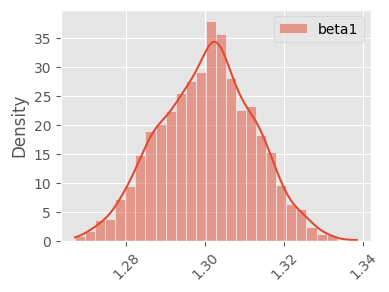

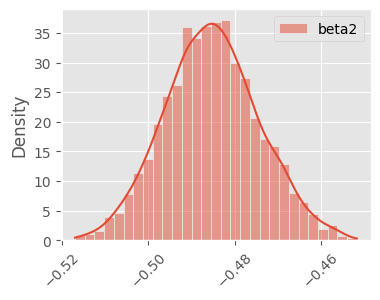

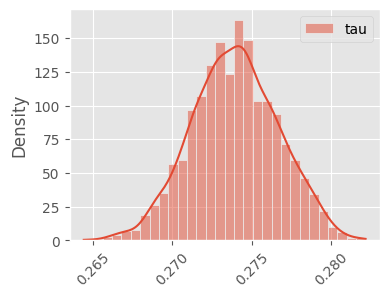

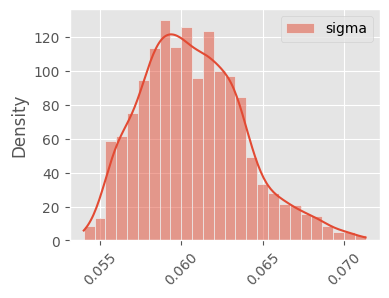

In [17]:
nodes = ["beta1","beta2", "tau", "sigma"]
for node in nodes:
    plt.figure(figsize=(4,3))
    sns.histplot(hmc_samples[node], label=node, kde=True, stat="density")
    plt.xticks(rotation=45)
    plt.legend()
    plt.savefig(f"plots/{node}_histogram.png",bbox_inches='tight')
    plt.show()

In [41]:
y_hat = hmc_samples["y_pred"].mean(axis=0)
y_std = hmc_samples["y_pred"].std(axis=0)

y_hat_norm = y_hat

In [29]:
predictions_temporal_MMCA = y_hat * y_true_std + y_true_mean

We now plot the true price and the predicted price, which seems to correspond somewhat, albeit still ith some difference. The overall dynamics are however captured.

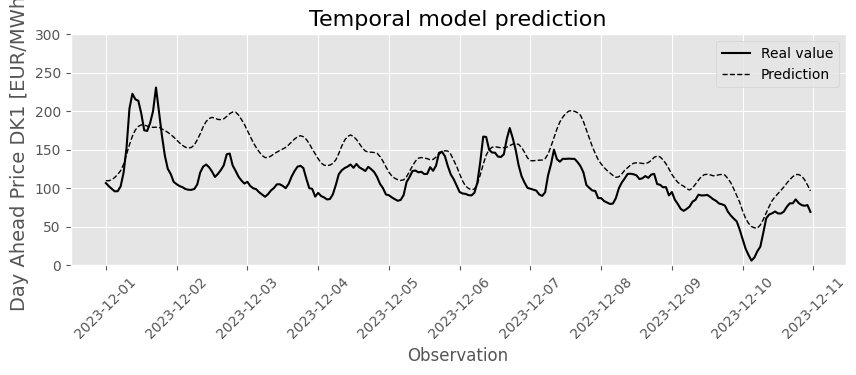

In [42]:
y_pred_true = (y_test.to_numpy() * y_true_std) + y_true_mean
y_hat = (y_hat * y_true_std) + y_true_mean

plt.figure(figsize=(10,3))
plt.plot(y_test.index[:10*24], y_pred_true[:10*24], color = 'black')
plt.plot(y_test.index[:10*24], y_hat[:10*24], color = 'black', linestyle='--', linewidth=1)
plt.xlabel("Observation", fontsize=12)
plt.ylabel("Day Ahead Price DK1 [EUR/MWh]", fontsize=14)
plt.xticks(fontsize=10, rotation=45)
plt.ylim([0,300])
#plt.xlim([0, T_forecast])
plt.legend(["Real value", "Prediction"])
plt.title("Temporal model prediction", fontsize=16)
plt.savefig('plots/temporal_model_prediction.png', bbox_inches='tight')
plt.show()


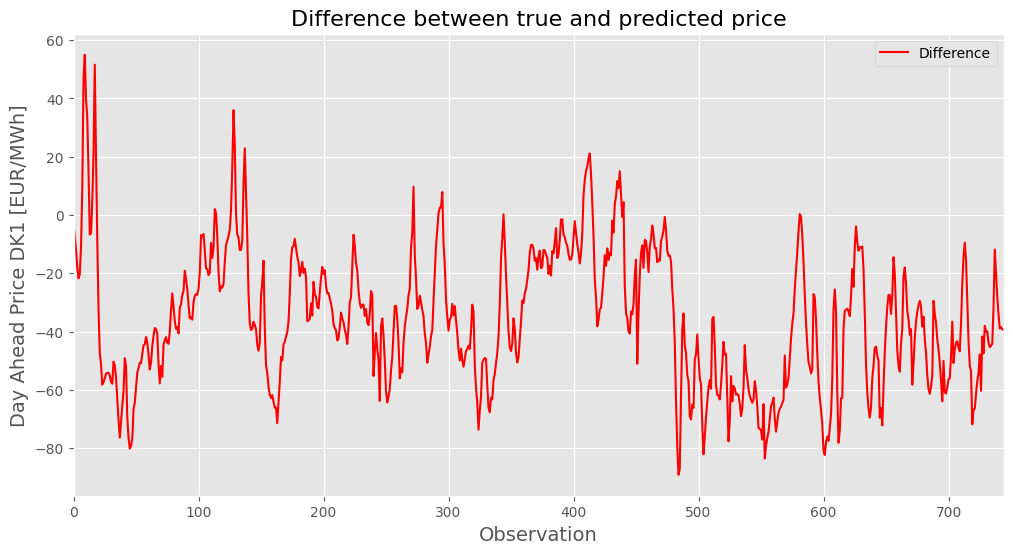

In [31]:
y_diff = y_pred_true - y_hat
plt.figure(figsize=(12,6))
plt.plot(np.arange(T_forecast), y_diff, color = 'black')
plt.xlabel("Observation", fontsize=14)
plt.ylabel("Day Ahead Price DK1 [EUR/MWh]", fontsize=14)
plt.xlim([0, T_forecast])
plt.legend(["Difference"])
plt.title("Difference between true and predicted price", fontsize=16)
# plt.savefig('plots/temporal_model_prediction.png', bbox_inches='tight')
plt.show()

We now also compute various error statistics, namely the correlation coefficient, Mean Absolute Error (MAE) and the Root Mean Square Error (RMSE).

In [32]:
def compute_error(trues, predicted):
    import numpy
    corr = numpy.corrcoef(predicted, trues)[0,1]
    mae = numpy.mean(np.abs(predicted - trues))
    rae = numpy.sum(numpy.abs(predicted - trues)) / numpy.sum(numpy.abs(trues - numpy.mean(trues)))
    rmse = numpy.sqrt(numpy.mean((predicted - trues)**2))
    r2 = max(0, 1 - numpy.sum((trues-predicted)**2) / numpy.sum((trues - numpy.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [33]:
corr, mae, rae, rmse, r2 = compute_error(y_test.to_numpy(), y_hat_norm)
print("CorrCoef: %.3f\nMAE: %.5f\nRMSE: %.5f" % (corr, mae, rmse))

CorrCoef: 0.855
MAE: 0.75831
RMSE: 0.86516


# Multivariate LDS with input

As stated earlier, there is an interaction between neighbouring bidding zones, which influence the day-ahead price in the zones. Thus, the model is expanded into a multivariate linear dynamical system to capture the correlation between neighbouring bidding zones. The primary difference from the previous model for a single bidding zone is that we group the day-ahead prices for all investigated bidding zones into one observation vector, $\bm{y}_t = (y_t^1, \dots , y_t^M)$, with *M* being the number of investigated bidding zones. 

The main difference is that the transmission noise is now modelled using a full matrix, $\Sigma$. 

![](PGM_Multivariate.png)

Since we expect some interaction, we now need to process the data a little differently. We now output the price for all investigated zones in a new dataframe, `price` with the input parameters being put in the dataframe `df_new`. 

There are some numerical instabilities in the model or the data, so the model currently only predicts for two related bidding zones. This is ensured by setting a limit to the for-loop. 

In [47]:
df = pd.read_csv("data/2023/nordic_energy_data.csv")

uniqueBiddingZones = df['country_code'].unique()
#print(uniqueBiddingZones)

# Create new dataframe with only timestamp
df_new = transpose_for_country_code(df, 'DK_1')
df_new = df_new["Timestamp"]
price = df_new

# Drop column "Unnamed: 0"
df = df.drop(columns=['Unnamed: 0', 'Actual Load'])
df = df.loc[:,(~df.columns.str.contains("Ex") & ~df.columns.str.contains("Imp"))]
df = df.loc[:,(~df.columns.str.contains("Cap"))]
df = df.rename(columns={'DA-price [EUR/MWh]': 'Price'})

biddingZone = 'DK_1'

for biddingZone in uniqueBiddingZones[:2]:
    df_country = df[df['country_code'] == biddingZone]
    # Make NaN values = 0
    df_country = df_country.fillna(0)
    # Drop columns that are all 0
    df_country = df_country.loc[:, (df_country != 0).any(axis=0)]
    # Drop columns where the valye for all rows are the same
    df_country = df_country.loc[:, df_country.nunique() != 1]
    # Add suffix to columns indicating country code
    excludeCol = 'Timestamp'
    suffix = '_%s' % biddingZone
    newColNames = {col: f"{col}{suffix}" for col in df_country.columns if col != excludeCol}
    df_country = df_country.rename(columns = newColNames)

    price = pd.merge(price, df_country.iloc[:, :2], on='Timestamp', how='left')

    df_country = df_country.drop(columns=['Price%s' % suffix])
    df_new = pd.merge(df_new, df_country, on='Timestamp', how='left')

df_new = df_new.loc[:, df_new.nunique() != 1]

df_new = cyclical_transformation(df_new)

df_new["Timestamp"] = pd.to_datetime(df_new["Timestamp"])
df_new.set_index("Timestamp", inplace=True)
price["Timestamp"] = pd.to_datetime(price["Timestamp"])
price.set_index("Timestamp", inplace=True)

df_new.head()

Forecasted Load_DK_1  Forecasted Generation_DK_1  \
Timestamp                                                               
2023-01-01 00:00:00                2135.0                       832.0   
2023-01-01 01:00:00                2084.0                       974.0   
2023-01-01 02:00:00                2059.0                      1165.0   
2023-01-01 03:00:00                2001.0                      1437.0   
2023-01-01 04:00:00                1969.0                      1517.0   

                     Solar_DK_1  Wind Offshore_DK_1  Wind Onshore_DK_1  \
Timestamp                                                                
2023-01-01 00:00:00         0.0                75.0              556.0   
2023-01-01 01:00:00         0.0               146.0              639.0   
2023-01-01 02:00:00         0.0               328.0              735.0   
2023-01-01 03:00:00         0.0               376.0              870.0   
2023-01-01 04:00:00         0.0               429.0             1047.0   

                     Forecasted Load_DK_2  Forecasted Generation_DK_2  \
Timestamp                                                               
2023-01-01 00:00:00                1279.0                      1360.0   
2023-01-01 01:00:00                1243.0                      1340.0   
2023-01-01 02:00:00                1230.0                      1178.0   
2023-01-01 03:00:00                1172.0                      1207.0   
2023-01-01 04:00:00                1126.0                      1154.0   

                     Solar_DK_2  Wind Offshore_DK_2  Wind Onshore_DK_2  \
Timestamp                                                                
2023-01-01 00:00:00         0.0               319.0              423.0   
2023-01-01 01:00:00         0.0               331.0              469.0   
2023-01-01 02:00:00         0.0               324.0              502.0   
2023-01-01 03:00:00         0.0               319.0              522.0   
2023-01-01 04:00:00         0.0               327.0              529.0   

                     Hour_sin  Hour_cos   Day_sin  Day_cos  
Timestamp                                                   
2023-01-01 00:00:00  0.000000  1.000000  0.781831  0.62349  
2023-01-01 01:00:00  0.258819  0.965926  0.781831  0.62349  
2023-01-01 02:00:00  0.500000  0.866025  0.781831  0.62349  
2023-01-01 03:00:00  0.707107  0.707107  0.781831  0.62349  
2023-01-01 04:00:00  0.866025  0.500000  0.781831  0.62349

Split the data as earlier.

In [ ]:
# Limit data used
#df_new = df_new.iloc[:100*24,:]
#price = price.iloc[:100*24,:]

# Split and normalize data
test_days = 31

len_df = len(df_new)
test_size = (test_days * 24) / len_df

X_train, X_test, y_train, y_test = train_test_split(df_new, price, test_size=test_size, shuffle=False)

# Normalize the data based on the training set
x_train_mean = X_train.mean()
x_train_std = X_train.std()
y_train_mean = y_train.mean()
y_train_std = y_train.std()

# Normalize the data based on the training set
X_train = (X_train - x_train_mean) / x_train_std
X_test = (X_test - x_train_mean) / x_train_std
y_train = (y_train - y_train_mean) / y_train_std
y_test = (y_test - y_train_mean) / y_train_std

# make NaN and Inf 0
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
y_train = y_train.fillna(0)
y_test = y_test.fillna(0)
X_train = X_train.replace([np.inf, -np.inf], 0)
X_test = X_test.replace([np.inf, -np.inf], 0)
# drop columns that are all 0
X_train = X_train.loc[:, (X_train != 0).any(axis=0)]
X_test = X_test.loc[:, (X_test != 0).any(axis=0)]

In [ ]:
T = len(y_train)
T_forecast = len(y_test)

# Remove first two input values since we use an AR(2) model
x = pd.concat([X_train[2:], X_test]).to_numpy()
x = x[:,:5] # only use first 5 parameters 
y = y_train.to_numpy()

N,D = x.shape
M = y.shape[1]

ix_obs = np.arange(T)

y_true_std = y_train_std
y_true_mean = y_train_mean

print("T=%d" % T)
print("T_forecast=%d" % T_forecast)
print("N=%d, D=%d" % (N,D))
print("M=%d" % M)

T=7992
T_forecast=744
N=8734, D=5
M=2


In [ ]:
def f(carry, input_t):
    # carry contains:
    #   B       : sampled from a prior
    #   W       : sampled from prior i guess
    #   h_prev  : the previous value
    #   tau     : parameter for parametrization of noise
    B1, B2, W, h_prev1, h_prev2, tau = carry
    # inputs are:
    #   noise_t : noise at time stamp t
    #   x_t     : input weather data at time stamp t
    x_t, noise_t = input_t
    # Calculation
    h_t = jnp.matmul(B1,h_prev1) + jnp.matmul(B2,h_prev2) + jnp.matmul(W, x_t) + tau*noise_t
    h_prev2 = h_prev1
    h_prev1 = h_t
    
    return (B1,B2, W, h_prev1,h_prev2, tau), h_t

The model follows the standard approach of using an LKJ distribution as the prior for the covariance matrix, given by
\begin{align}
\boldsymbol\Sigma_{lowertriangular} = \mathbf{diag}(\boldsymbol\tau) \, \boldsymbol\Omega
\end{align}

In [ ]:
def model(T, T_forecast, x_t, obs=None):
    # Define priors over B, R, W, c
    B1 = numpyro.sample("B1", dist.Normal(loc=jnp.zeros((M,M)), scale=jnp.ones((M,M))))
    B2 = numpyro.sample("B2", dist.Normal(loc=jnp.zeros((M,M)), scale=jnp.ones((M,M))))
    W = numpyro.sample("W", dist.Normal(loc=jnp.zeros((M,D)), scale=jnp.ones((M,D))))

    tau = numpyro.sample("tau", dist.HalfCauchy(scale=0.1 * jnp.ones(M)))

    # Ensure tau has no negative values
    #tau = jnp.clip(tau, a_min=1e-6, a_max=None)

    sigma = numpyro.sample("sigma", dist.HalfCauchy(scale=.1))

    h_prev1 = numpyro.sample("h_prev1", dist.Normal(loc=jnp.zeros(M), scale=0.1 * jnp.ones(M)))
    h_prev2 = numpyro.sample("h_prev2", dist.Normal(loc=jnp.zeros(M), scale=0.1 * jnp.ones(M)))

    # LKJ prior
    L_Omega = numpyro.sample("L_Omega", dist.LKJCholesky(M, 10.))
    Sigma_lower = jnp.matmul(jnp.diag(jnp.sqrt(tau)), L_Omega)
    noises_t = numpyro.sample("noises_t", dist.MultivariateNormal(loc=jnp.zeros(M), scale_tril=Sigma_lower), sample_shape=(T+T_forecast-2,))

    # Propagate the dynamics using jax.lax.scan
    carry = (B1, B2, W, h_prev1, h_prev2, tau)
    input_t = (x_t, noises_t)
    h_collection = [h_prev1, h_prev2]
    carry, hs_exp = lax.scan(f, carry, input_t, T+T_forecast-2)
    h_collection = jnp.concatenate((jnp.array(h_collection), hs_exp), axis=0)

    R = sigma*jnp.eye(M)

    # Sample observed and missing values
    numpyro.sample("y_obs", dist.MultivariateNormal(loc=h_collection[:T], covariance_matrix=R), obs=obs)
    if T_forecast>0:
        numpyro.sample("y_pred", dist.MultivariateNormal(loc=h_collection[T:], covariance_matrix=R), obs=None)
    return h_collection

In [ ]:
t_start = time.time()

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
nuts_kernel = NUTS(model=model)
mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=1000, num_chains=2)
mcmc.run(rng_key_, T=T, T_forecast=T_forecast, 
         x_t=x, obs=y)

/var/folders/yv/5qf9yfms5h77gqr4g5tzmzzh0000gn/T/ipykernel_66048/2568822878.py:6: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=1000, num_chains=2)
sample: 100%|██████████| 3000/3000 [35:18<00:00,  1.42it/s, 1023 steps of size 1.13e-03. acc. prob=0.93]


The `r_hat` values shown below seems to indicate that the model has not fully converged. However, there is also a limit to the time it is feasible to run the model, giving us the results seen here. 

In [ ]:
mcmc.print_summary()


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
         B1[0,0]      1.32      0.02      1.32      1.29      1.34     24.29      1.12
         B1[0,1]     -0.04      0.02     -0.04     -0.07     -0.01     18.86      1.10
         B1[1,0]      0.11      0.02      0.11      0.09      0.15     24.64      1.10
         B1[1,1]      1.15      0.02      1.15      1.11      1.17     15.97      1.15
         B2[0,0]     -0.49      0.02     -0.49     -0.52     -0.45     22.23      1.15
         B2[0,1]      0.02      0.02      0.02     -0.01      0.05     19.87      1.13
         B2[1,0]     -0.16      0.02     -0.16     -0.20     -0.13     17.93      1.15
         B2[1,1]     -0.29      0.02     -0.29     -0.32     -0.25     14.05      1.19
    L_Omega[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
    L_Omega[0,1]      0.00      0.00      0.00      0.00      0.00       nan       nan
    L_Omega[1,0]      0.85      0.00      

In [ ]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

# Save the dictionary
import pickle

with open('multivariate_data.pkl', 'wb') as fp:
    pickle.dump(hmc_samples, fp)
    print('Multivariate results saved to file')

Multivariate results saved to file


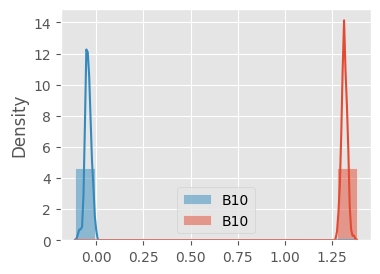

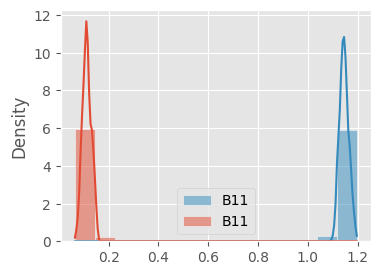

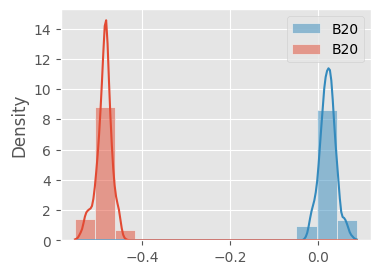

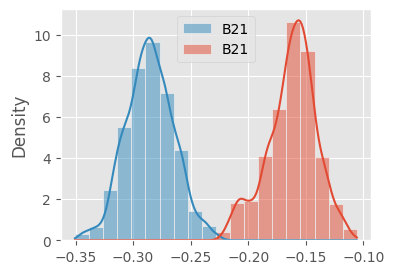

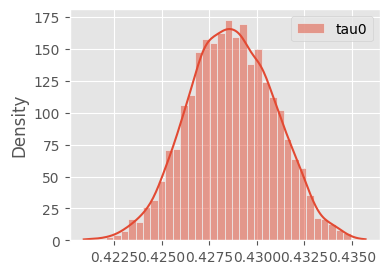

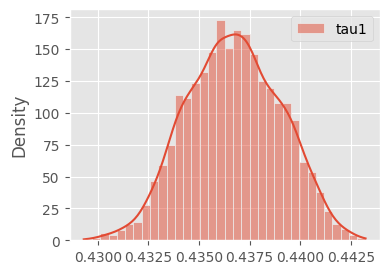

In [ ]:
nodes = ["B1", "B2", "tau"]
for node in nodes:
  if node in ("B1", "B2", "tau"):
    for i in range(M):
      plt.figure(figsize=(4,3))
      sns.histplot(hmc_samples[node][:,i], label=node+"%d"%i, kde=True, stat="density")
      plt.legend()
    plt.show()

In [ ]:
y_hat = hmc_samples["y_pred"].mean(axis=0)
y_std = hmc_samples["y_pred"].std(axis=0)
#y_pred_true = y_test.to_numpy()
y_pred_true = (y_test.to_numpy() * y_true_std.to_numpy()) + y_true_mean.to_numpy()
y_hat = (y_hat * y_true_std.to_numpy()) + y_true_mean.to_numpy()

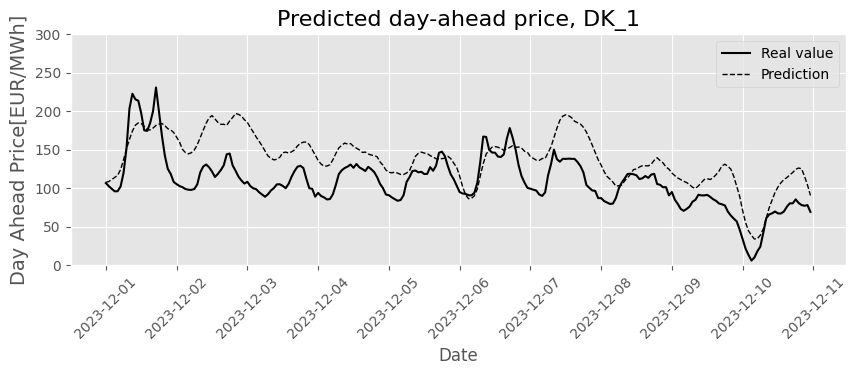

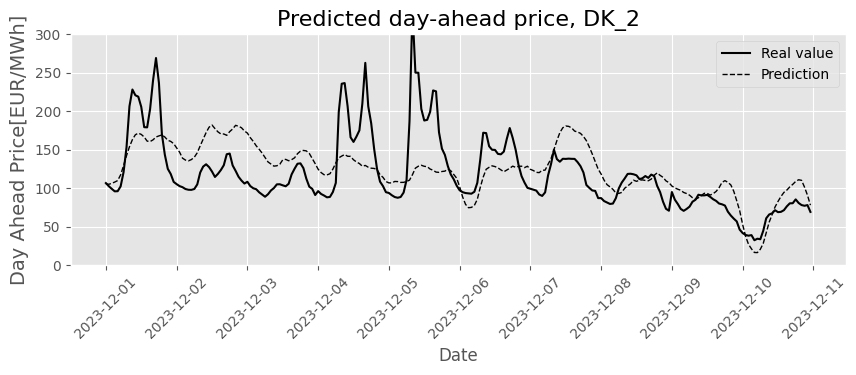

In [ ]:
#y_pred_true = (y_test.to_numpy() * y_true_std) + y_true_mean
#y_hat = (y_hat * y_true_std) + y_true_mean

for ii in np.arange(y_hat.shape[1]):
    plt.figure(figsize=(10,3))
    plt.plot(y_test.index[:10*24], y_pred_true[:10*24, ii], color = 'black')
    plt.plot(y_test.index[:10*24], y_hat[:10*24, ii], color = 'black', linestyle='--', linewidth=1)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Day Ahead Price[EUR/MWh]", fontsize=14)
    plt.xticks(fontsize=10, rotation=45)
    plt.ylim([0, 300])
    #plt.xlim([0, T_forecast])
    plt.legend(["Real value", "Prediction"])
    plt.title("Predicted day-ahead price, %s" % uniqueBiddingZones[ii], fontsize=16)
    plt.savefig('plots/%s_predicted_price.png' % uniqueBiddingZones[ii], bbox_inches='tight')
    plt.show()

[  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336 360 384 408
 432 456 480 504 528 552 576 600 624 648 672 696 720]


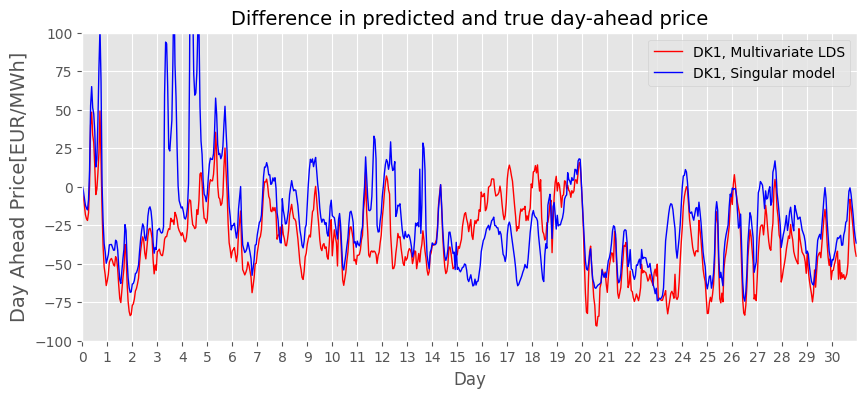

In [ ]:
y_difference = y_pred_true - y_hat

ticks = np.arange(test_days) * 24 
print(ticks)

plt.figure(figsize=(10,4))
plt.plot(np.arange(T_forecast), y_difference[:, 0], color='red', linewidth=1)
#plt.plot(np.arange(T_forecast), y_pred_true[:, 0] - predictions_temporal_MMCA, color='red', linestyle='--', linewidth=1)
plt.plot(np.arange(T_forecast), y_difference[:, 1], linewidth=1, color='blue')
plt.xlabel("Day", fontsize=12)
plt.ylabel("Day Ahead Price[EUR/MWh]", fontsize=14)
plt.xlim([0, T_forecast])
plt.ylim([-100, 100])
plt.xticks(ticks, np.arange(test_days))
plt.legend(["DK1, Multivariate LDS", "DK1, Singular model", "DK2, Multivariate LDS"])
plt.title("Difference in predicted and true day-ahead price", fontsize=14)
# plt.savefig('plots/temporal_model_prediction.png', bbox_inches='tight')
plt.show()

In [ ]:
def compute_error(trues, predicted):
    import numpy
    corr = numpy.corrcoef(predicted, trues)[0,1]
    mae = numpy.mean(np.abs(predicted - trues))
    rae = numpy.sum(numpy.abs(predicted - trues)) / numpy.sum(numpy.abs(trues - numpy.mean(trues)))
    rmse = numpy.sqrt(numpy.mean((predicted - trues)**2))
    r2 = max(0, 1 - numpy.sum((trues-predicted)**2) / numpy.sum((trues - numpy.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [ ]:
corr_DK1, mae_DK1, rae_DK1, rmse_DK1, r2_DK1 = compute_error(y_pred_true[:,0], y_hat[:,0])
print("DK1: \nCorrCoef: %.3f\nMAE: %.5f\nRMSE: %.5f" % (corr_DK1, mae_DK1, rmse_DK1))

corr_DK2, mae_DK2, rae_DK2, rmse_DK2, r2_DK2 = compute_error(y_pred_true[:,1], y_hat[:,1])
print("\nDK2: \nCorrCoef: %.3f\nMAE: %.5f\nRMSE: %.5f" % (corr_DK2, mae_DK2, rmse_DK2))

DK1: 
CorrCoef: 0.842
MAE: 0.73796
RMSE: 0.85813

DK2: 
CorrCoef: 0.800
MAE: 0.65600
RMSE: 0.78611


# Simple Gaussian Process Models

Gaussian Processes (GPs) is a powerful non-parametric, probabilistic technique that is especially useful for time series forecast problems involving continuous data with complex relationships. This makes GP a relevant technique for this project. In this project, a simple GP model is created  where we compare different Kernel (Covariance) Functions.


Although GPs are non-parametric models, there are still important choices to be made and hyperparameters to be tuned in order to create a good model. One of these is the choice of kernel, which defines the model behaviour by measuring pairwise similarities between data points. For this project, a combination of the Squared Exponential (SE) and Periodic kernels were chosen which will be investigated below. 

In [5]:
# Define Covariance functions
def covSE(x1, x2, cov_params=[2.0]):
    return np.exp(-cov_params[0]*np.sum((x1 - x2)**2))

def covPER(x1, x2, cov_params):
    return cov_params[0] * np.exp(-cov_params[1] * np.sum( np.sin(np.pi*(x1-x2)/cov_params[2])**2 ))

def covWN(x1, x2, cov_params):
    if x1.any() == x2.any():
        return cov_params[0]
    else:
        return 0

def cov(x1, x2, cov_fn, cov_params):
    K = np.zeros((len(x1), len(x2)))
    for i in range(len(x1)):
        for j in range(len(x2)):
            K[i,j] = cov_fn(x1[i,:], x2[j,:], cov_params)
    return K

def covSUM_WN_SE(x1, x2, cov_params):
    K = covWN(x1, x2, cov_params[:1]) + covSE(x1, x2, cov_params[1:])
    return K

def covSUM_PER_SE(x1, x2, cov_params):
    return covPER(x1, x2, cov_params[:3]) + covSE(x1, x2, cov_params[3:])

def make_and_plot_cov(X, cov_func, cov_params,fig_name = ''):

    # construct K
    K = cov(X, X, cov_func, cov_params)
    plt.figure(figsize=(8,7))
    plt.imshow(K)
    plt.title("Covariance matrix from Gaussian process prior")
    plt.xlabel("Observations")
    plt.ylabel("Observations")
    plt.colorbar() 
    plt.savefig('plots/'+fig_name, bbox_inches='tight')
    plt.show()
    return K

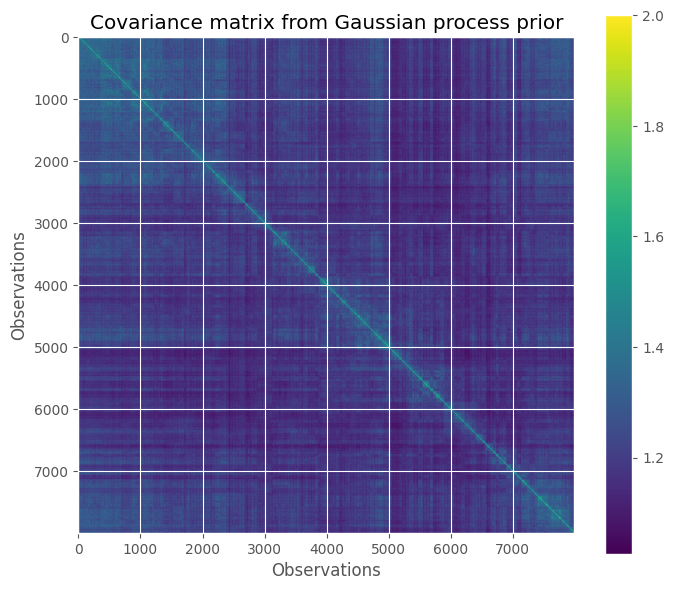

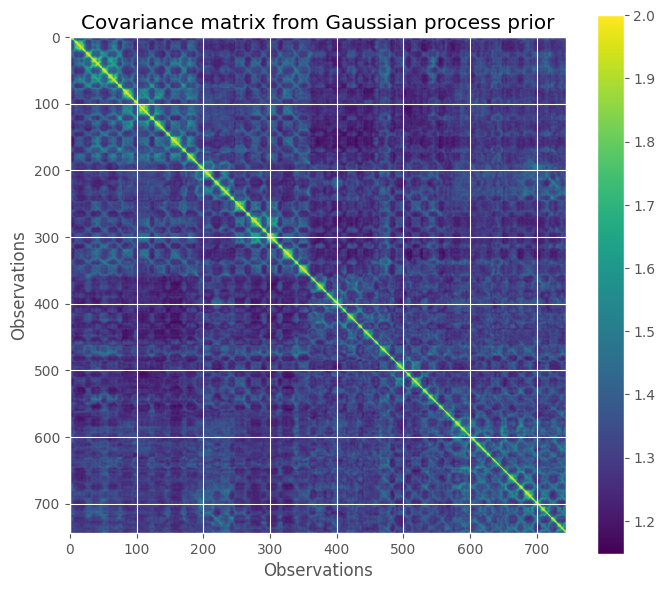

In [18]:
# Plot covariance matrices K and K_star_star
K = make_and_plot_cov(X_train_num, covSUM_PER_SE, [1, 0.05, 2, 0.0001], fig_name = 'covariance_matrix.png')
K = make_and_plot_cov(X_test_num, covSUM_PER_SE,[1, 0.05, 2, 0.0001], fig_name = 'covariance_matrix_test.png')

Run the simple GP model.

In [19]:
start_time_gp = time.time() # Start time for GP model
# Function to compute the predictive posterior
def compute_predictive_posterior(X_test_num, X_train_num, sigma, cov_params):
    N_test = len(X_test_num) # Number of test observations

    predictions_gp = np.zeros(N_test) # Initialize array for predictions
    variances = np.zeros(N_test) # Initialize array for variances
    
    # Using the covariance function covSUM_PER_SE 
    K = cov(X_train_num, X_train_num, covSUM_PER_SE, cov_params) # Covariance matrix for training data
    k_star = cov(X_train_num, X_test_num, covSUM_PER_SE, cov_params) 
    k_star_star = cov(X_test_num, X_test_num, covSUM_PER_SE, cov_params)
    
    # Compute the mean and standard deviation
    mean = k_star.T @ np.linalg.inv(sigma**2*np.eye(X_train_num.shape[0]) + K) @ y_train_num
    std = k_star_star + sigma**2 - k_star.T @ np.linalg.inv(sigma**2 * np.eye(X_train_num.shape[0]) + K) @ k_star

    # Sample from the predictive posterior
    predictions_gp =  np.random.multivariate_normal(mean.squeeze(), std)

    # Compute the variances
    variances = np.diag(std)
    
    return predictions_gp, variances, mean, std, K

# Define parameters
cov_params = [1, 0.05, 2, 0.0001] # relatively good for PER_SE

sigma = 0.01
# Run model
predictions_gp, variances, mean, std, K = compute_predictive_posterior(X_test_num, X_train_num, sigma, cov_params)

end_time_gp = time.time() # End time for GP model
minutes, seconds = divmod(end_time_gp - start_time_gp, 60)
print(f"Execution time for GP model: {minutes:0.0f}m {seconds:0.0f}s")

Execution time for GP model: 12m 40s


## Gaussian Model using sklearn-package

We now create the model using the `sklearn` library. 

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ExpSineSquared, WhiteKernel, RBF
cov_params = [1, 0.05, 2, 0.0001] # relatively good for PER_SE
start_time_gp_sk = time.time()
# Define the kernel using the same parameters as in the custom GP model
ESS_c = cov_params[0]
ESS_ls = cov_params[1]
ESS_per = cov_params[2]
rbf_c = 1
rbf_ls = cov_params[3]

# Define the kernel
kernel = ESS_c * ExpSineSquared(length_scale=ESS_ls, periodicity=ESS_per) + rbf_c * RBF(length_scale=rbf_ls)
# Initialize the Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Fit the Gaussian Process model
gp.fit(X_train_num, y_train_num)

# Make predictions on the test set
y_pred_GP_SK, y_std_GP_SK = gp.predict(X_test_num, return_std=True)
# Convert the predictions back to the original scale
y_pred_GP_SK_back_transformed = y_pred_GP_SK*y_train_std + y_train_mean

end_time_gp_sk = time.time() # End time for GP model with sklearn

minutes, seconds = divmod(end_time_gp_sk - start_time_gp_sk, 60)
print(f"Execution time for GP model with sklearn: {minutes:0.0f}m {seconds:0.0f}s")





Execution time for GP model with sklearn: 105m 38s


From the comparison below, it can be seen that the predicted prices follow the general temporal dynamics of the actual prices quite well, while still overshooting somewhat. 

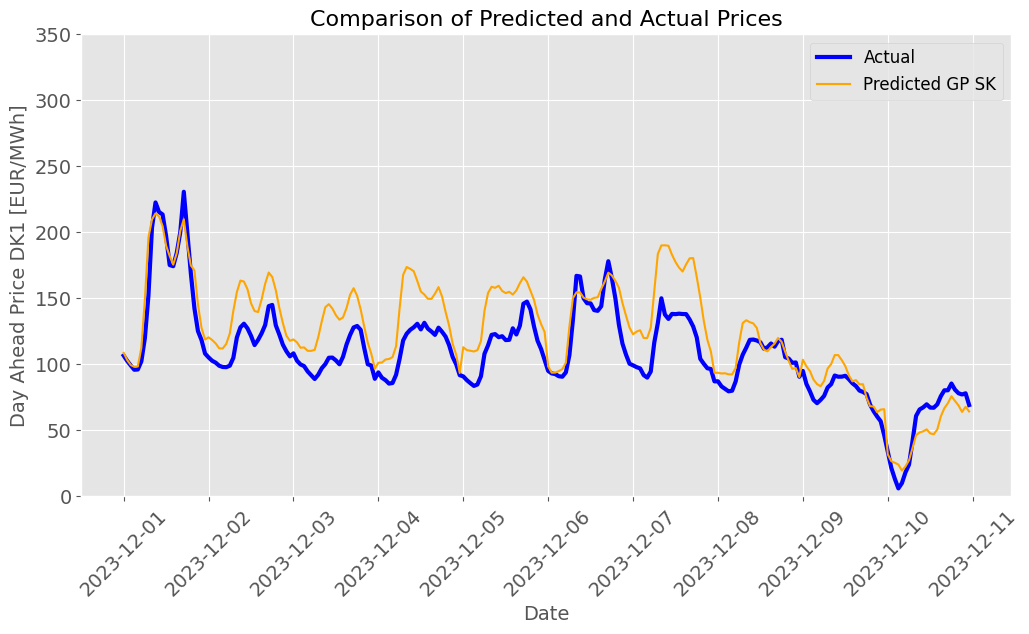

In [4]:

y_test_num_back_transformed = y_test_num*y_train_std + y_train_mean # Convert back to original scale
# Plot the predicted and actual prices
plt.figure(figsize=(12, 6))
plt.plot(y_test.index[:10*24], y_test_num_back_transformed[:10*24], label="Actual", color="blue", linewidth=3)
plt.plot(y_test.index[:10*24], y_pred_GP_SK_back_transformed[:10*24], label="Predicted GP SK", color="orange")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Day Ahead Price DK1 [EUR/MWh]", fontsize=14)
plt.title("Comparison of Predicted and Actual Prices", fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.ylim([0, 350])
plt.savefig('plots/comparison_of_predicted_and_actual_prices_DK1_GPSK.png', bbox_inches='tight')
plt.legend(fontsize=12)
plt.show()

In [34]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Compute error measures
corr_temporal, mae_temporal, rae_temporal, rmse_temporal, r2_temporal = compute_error(y_test_num, y_hat)
corr_GP_SK, mae_GP_SK, rae_GP_SK, rmse_GP_SK, r2_GP_SK = compute_error(y_test_num, y_pred_GP_SK)
corr_GP_own, mae_GP_own, rae_GP_own, rmse_GP_own, r2_GP_own = compute_error(y_test_num, predictions_gp)

# Create a table to display the error measures
import pandas as pd

data = {
    "Model": ["Temporal", "GP from scikit-learn", "Self-made GP"],
    "Correlation": [corr_temporal, corr_GP_SK, corr_GP_own],
    "MAE": [mae_temporal, mae_GP_SK, mae_GP_own],
    "RAE": [rae_temporal, rae_GP_SK, rae_GP_own],
    "RMSE": [rmse_temporal, rmse_GP_SK, rmse_GP_own],
    "R^2": [r2_temporal, r2_GP_SK, r2_GP_own]
    
}

errors = pd.DataFrame(data)
print("\nError Measures Overview:")
print(errors)


Error Measures Overview:
                  Model  Correlation       MAE       RAE      RMSE       R^2
0              Temporal     0.708766  0.652933  0.883706  0.835456  0.127359
1  GP from scikit-learn     0.935795  0.410993  0.556254  0.503908  0.682539
2          Self-made GP     0.433340  0.803547  1.087553  0.999618  0.000000


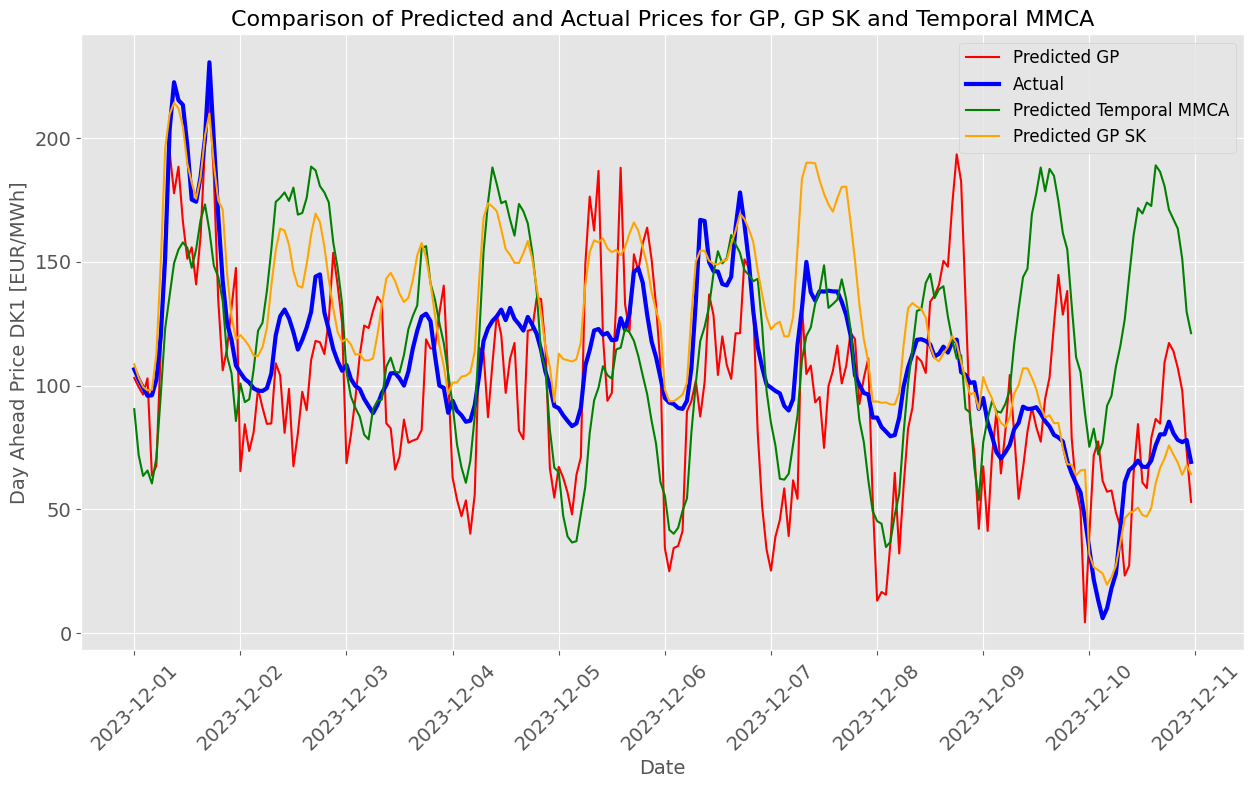

In [39]:

# Plot results for all three models
predictions_gp_std = (predictions_gp * y_train_std) + y_train_mean# Convert back to original scale
y_test_num_std = (y_test_num * y_train_std) + y_train_mean # Convert back to original scale
# Plot the predicted and actual prices for GP, GP SK and Temporal MMCA
plt.figure(figsize=(15, 8))
plt.plot(y_test.index[:10*24], predictions_gp_std[:10*24], label="Predicted GP", color="red")
plt.plot(y_test.index[:10*24], y_test_num_std[:10*24], label="Actual", color="blue", linewidth=3)
plt.plot(y_test.index[:10*24], predictions_temporal_MMCA[:10*24], label="Predicted Temporal MMCA", color="green")
plt.plot(y_test.index[:10*24], y_pred_GP_SK_back_transformed[:10*24], label="Predicted GP SK", color="orange")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Day Ahead Price DK1 [EUR/MWh]", fontsize=14)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.title("Comparison of Predicted and Actual Prices for GP, GP SK and Temporal MMCA", fontsize=16)
plt.legend(fontsize=12)
plt.savefig('plots/comparison_of_predicted_and_actual_prices.png', bbox_inches='tight')
plt.show()

### Estimating the most important features

To provide insights into feature importance in a Gaussian Process (GP) model, we can use a method that examines the sensitivity of the model's predictions to perturbations in each feature. This method can be understood as a local approximation of feature importance, and it involves observing how the predictions change as we slightly alter each feature while holding others constant. We'll apply small perturbations to each feature across the dataset and monitor the variance in the predictions.

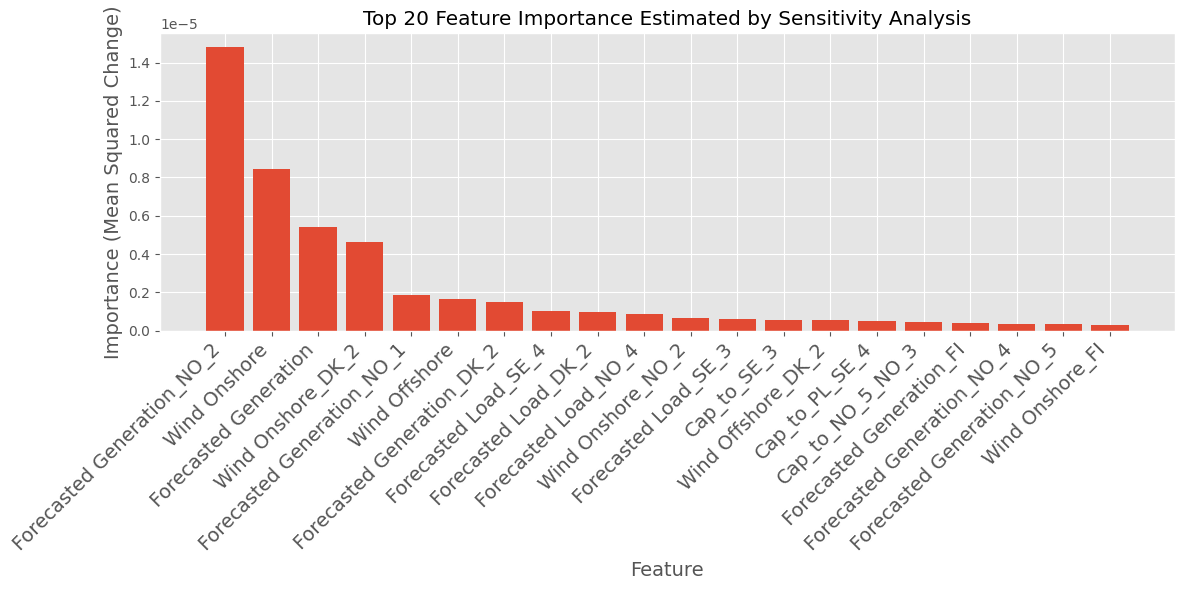

Execution time for sensitivity analysis: 2m 51s


In [24]:
#Choose a perturbation level (typically a small percentage of the feature's standard deviation).
#Perturb each feature one at a time in the test dataset, and observe the change in predictions.
#Calculate the mean squared change in predictions for each feature to estimate its relative importance.
start_time_sensitivity = time.time()
def feature_importance(gp, X, feature_names, epsilon=0.01):
    importances = np.zeros(X.shape[1])
    
    # Baseline prediction with original X
    baseline_pred = gp.predict(X)
    
    # Iterating over each feature
    for i in range(X.shape[1]):
        X_perturbed = np.copy(X)
        std_dev = np.std(X[:, i])
        
        # Perturbing the feature
        X_perturbed[:, i] += epsilon * std_dev
        
        # Predicting with perturbed data
        perturbed_pred = gp.predict(X_perturbed)
        
        # Calculating the mean squared difference
        importances[i] = np.mean((perturbed_pred - baseline_pred) ** 2)
    
    # Sort features by importance
    indices = np.argsort(importances)[::-1]
    sorted_importances = importances[indices]
    sorted_feature_names = [feature_names[i] for i in indices]
    
    return sorted_importances, sorted_feature_names

# Feature names from the original dataset
feature_names = X_train.columns.tolist()

# Calculate feature importances
sorted_importances, sorted_feature_names = feature_importance(gp, X_test_num, feature_names)

# Select the top 20 features
top_features = sorted_importances[:20]
top_feature_names = sorted_feature_names[:20]

# Plotting the top 20 feature importances
plt.figure(figsize=(12, 6))
plt.bar(top_feature_names, top_features)
plt.xticks(rotation=45, ha="right", fontsize=14)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Importance (Mean Squared Change)', fontsize=14)
plt.title('Top 20 Feature Importance Estimated by Sensitivity Analysis')
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.savefig('plots/top_20_feature_importance.png', bbox_inches='tight')
plt.show()

end_time_sensitivity = time.time()

minutes, seconds = divmod(end_time_sensitivity - start_time_sensitivity, 60)
print(f"Execution time for sensitivity analysis: {minutes:0.0f}m {seconds:0.0f}s")


# Probabilistic Principal Component Analysis (PPCA)

The dataset used in this project is high-dimensional. Therefore, a probabilistic principal component analysis (PPCA) with Automatic Relevance Determination (ARD) is utilized to reduce the dimensions of the input data to investigate how differently the models perform on the original dataset and the PPCA projections, respectively. This assessment is based on runtime vs model performance.

C:\Users\Bruger\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


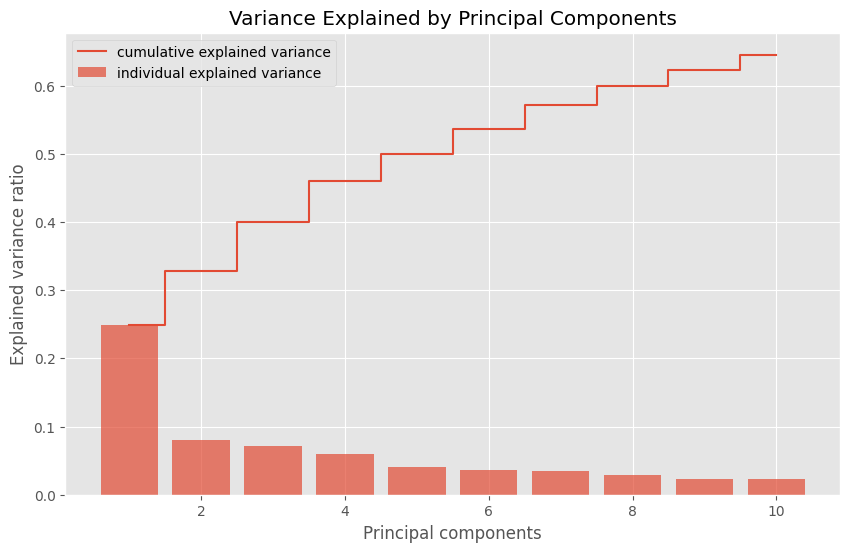

In [3]:
# Import libraries
import torch
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
from sklearn.decomposition import PCA

# Collect full data
X = pd.concat([X_train, X_test])
X = X.to_numpy()

# Make X torch for the Pyro model
X = torch.tensor(X, dtype=torch.float32)
y = pd.concat([y_train, y_test])

# Perform PCA
pca = PCA(n_components=10)
pca.fit(X)

# Explained variance
explained_variance = pca.explained_variance_ratio_

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, 11), explained_variance, alpha=0.7, align='center', label='individual explained variance')
plt.step(range(1, 11), np.cumsum(explained_variance), where='mid', label='cumulative explained variance')
plt.xlabel('Principal components')
plt.ylabel('Explained variance ratio')
plt.title('Variance Explained by Principal Components')
plt.legend(loc='best')
plt.show()

In [4]:
start_time_pca = time.time() # Start time for PCA model
#PPCA function:
def ppca_model_ard(X, latent_dim):
    input_dim = X.shape[1]
    sigma = pyro.sample("sigma", dist.HalfCauchy(1))
    alpha = pyro.sample("alpha", dist.Gamma(1.0, 1.0).expand([latent_dim]).to_event(1))
    w = pyro.sample("w", dist.Normal(torch.zeros([input_dim, latent_dim]), torch.sqrt(1.0 / alpha)).to_event(2))
    
    with pyro.plate("data", len(X)) as ind:
        z = pyro.sample("z", dist.Normal(torch.zeros(latent_dim), 1).to_event(1))
        x = pyro.sample("x", dist.Normal(torch.matmul(z, w.T), sigma).to_event(1), obs=X[ind])
    
    return x


# Guide function
guide = AutoNormal(ppca_model_ard)

# Reset parameter values
pyro.clear_param_store()

# Define the number of latent dimensions
latent_dim = 10

# Setup the optimizer
adam_params = {"lr": 0.005}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=3)
svi = SVI(ppca_model_ard, guide, optimizer, loss=elbo)

# Early stopping criteria
n_steps = 12000
early_stop_threshold = 1
early_stop_patience = 20
best_elbo = float('inf')
patience_counter = 0

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X, latent_dim)
    if step % 500 == 0: # Print ELBO every 500 steps
        print("[%d] ELBO: %.1f" % (step, elbo))

    # Check for early stopping
    if step % 100 == 0:
        if best_elbo - elbo < early_stop_threshold:
            patience_counter += 1
        else:
            patience_counter = 0
            best_elbo = elbo
        
        if patience_counter >= early_stop_patience:
            print(f"Early stopping at step {step} with ELBO: {elbo}")
            break

z_mean_ARD = pyro.get_param_store().get_param("AutoNormal.locs.z").detach().numpy() # Get the mean of z
w_mean_ARD = pyro.get_param_store().get_param("AutoNormal.locs.w").detach().numpy() # Get the mean of w
alpha_mean = pyro.get_param_store().get_param("AutoNormal.locs.alpha").detach().numpy()
print("z_mean.shape:", z_mean_ARD.shape)
print("w_mean.shape:", w_mean_ARD.shape)
print("alpha_mean:", alpha_mean)

reconstruction_ARD = np.matmul(z_mean_ARD, w_mean_ARD.T) # Reconstruct the data to see how well the model performs

mae = torch.mean(torch.abs(X-reconstruction_ARD))
rmse = torch.sqrt(torch.mean((X-reconstruction_ARD)**2))
print("Mean absolute error: {:.2f}".format(mae))
print("Root mean squared error: {:.2f}".format(rmse))



end_time_pca = time.time() # End time for PCA model

minutes, seconds = divmod(end_time_pca - start_time_pca, 60)
print(f"Execution time for constructing PCA: {minutes:0.0f}m {seconds:0.0f}s")

[0] ELBO: 1313876.3
[500] ELBO: 898472.4
[1000] ELBO: 889264.3
[1500] ELBO: 888056.2
[2000] ELBO: 887768.2
[2500] ELBO: 887287.9
[3000] ELBO: 886627.7
[3500] ELBO: 886014.4
[4000] ELBO: 885356.4
[4500] ELBO: 884801.9
[5000] ELBO: 884411.1
[5500] ELBO: 883987.4
[6000] ELBO: 883640.0
[6500] ELBO: 883359.8
[7000] ELBO: 883169.8
[7500] ELBO: 882974.8
[8000] ELBO: 882834.4
[8500] ELBO: 882799.6
[9000] ELBO: 882769.4
[9500] ELBO: 882743.5
[10000] ELBO: 882676.8
[10500] ELBO: 882656.0
[11000] ELBO: 882617.7
[11500] ELBO: 882639.1
z_mean.shape: (8736, 10)
w_mean.shape: (92, 10)
alpha_mean: [2.400808  2.9224815 2.9027154 2.5414562 2.3990002 3.1960177 3.2009132
 2.979082  1.3407272 3.0123446]
Mean absolute error: 0.40
Root mean squared error: 0.60
Execution time for constructing PCA: 36m 49s


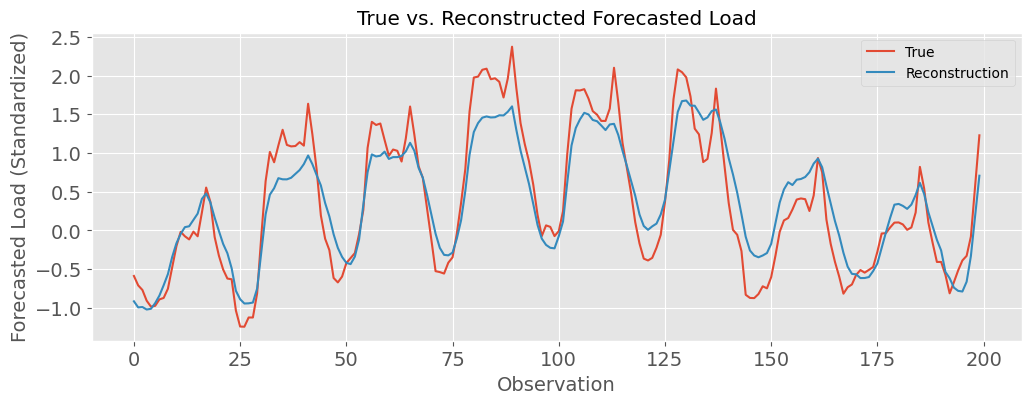

In [5]:
#%% Plot first column in X and the reconstruction to see how well the model is doing. Only plot first 200 samples
plt.figure(figsize=(12, 4))
plt.plot(X[:200,0], label="True")
plt.plot(reconstruction_ARD[:200,0], label="Reconstruction")
plt.ylabel("Forecasted Load (Standardized)", fontsize=14)
plt.xlabel("Observation", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("True vs. Reconstructed Forecasted Load")
plt.legend()
plt.savefig('plots/true_vs_reconstructed_forecasted_load.png', bbox_inches='tight')
plt.show()

In [6]:
len_z_mean = len(z_mean_ARD) 
test_size = (test_days * 24) / len_z_mean

# split the data into training and test set
Z_train_ARD, Z_test_ARD, _, _ = train_test_split(z_mean_ARD, y, test_size=test_size, shuffle=False)

# To numpy arrays
y_train_num = y_train.to_numpy().reshape(-1, 1)  # ravel() to convert y_train to 1D array
y_test_num = y_test.to_numpy().reshape(-1, 1)  # reshape(-1, 1) to convert y_test to 2D array

print(Z_train_ARD.shape)
print(Z_test_ARD.shape)
print(y_train_num.shape)
print(y_test_num.shape)

(7992, 10)
(744, 10)
(7992, 1)
(744, 1)


## Making GP with PPCA-data

Using the data found above in the Probabilistic PCA, we can now run a Gaussian Process model with these data. 

In [17]:
# Import libraries
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ExpSineSquared, WhiteKernel, RBF
start_time_gp_sk_ppca_ARD = time.time() # Start time for GP model with sklearn and PPCA
cov_params = [1, 0.05, 2, 0.0001]
# Define the kernel
ESS_c = cov_params[0]
ESS_ls = cov_params[1]
ESS_per = cov_params[2]
rbf_c = 1
rbf_ls = cov_params[3]

kernel_PPCA = ESS_c * ExpSineSquared(length_scale=ESS_ls, periodicity=ESS_per) + rbf_c * RBF(length_scale=rbf_ls)

# Define the kernel using the same parameters as in the custom GP model
gp_PPCA_ARD = GaussianProcessRegressor(kernel=kernel_PPCA, n_restarts_optimizer=10)

# Fit the Gaussian Process model
gp_PPCA_ARD.fit(Z_train_ARD, y_train_num)

# Make predictions on the test set
y_pred_GP_SK_PPCA_ARD, y_std_GP_SK_PPCA_ARD = gp_PPCA_ARD.predict(Z_test_ARD, return_std=True)

# Convert the predictions back to the original scale
y_pred_GP_SK_back_tranformed_PPCA_ARD = y_pred_GP_SK_PPCA_ARD*y_train_std + y_train_mean

end_time_gp_sk_ppca_ARD = time.time() # End time for GP model with sklearn and PPCA

minutes, seconds = divmod(end_time_gp_sk_ppca_ARD - start_time_gp_sk_ppca_ARD, 60)
print(f"Execution time for GP model with sklearn and PPCA: {minutes:0.0f}m {seconds:0.0f}s")

Execution time for GP model with sklearn and PPCA: 168m 36s


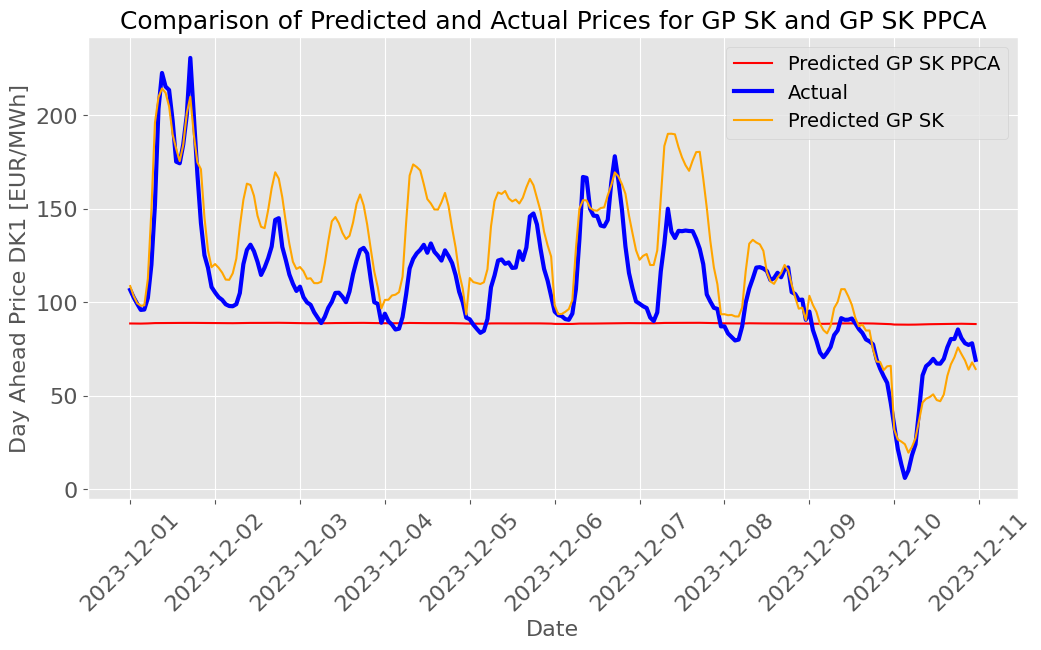

In [ ]:
y_pred_GP_SK = pd.read_csv("data/predictions.csv")["Predicted GP SK"].to_numpy()
y_pred_GP_SK_back_transformed = y_pred_GP_SK*y_train_std + y_train_mean
# Plot results of GP model with PPCA and ARD 
plt.figure(figsize=(12, 6))
plt.plot(y_test.index[:10*24], y_pred_GP_SK_back_tranformed_PPCA_ARD[:10*24], label="Predicted GP SK PPCA", color="red")
plt.plot(y_test.index[:10*24], y_test_num_std[:10*24], label="Actual", color="blue", linewidth=3)
plt.plot(y_test.index[:10*24], y_pred_GP_SK_back_transformed[:10*24], label="Predicted GP SK", color="orange")
plt.xlabel("Date", fontsize=16)
plt.ylabel("Day Ahead Price DK1 [EUR/MWh]", fontsize=16)
plt.title("Comparison of Predicted and Actual Prices for GP SK and GP SK PPCA", fontsize=18)
plt.xticks(fontsize=16, rotation=45)
plt.yticks(fontsize=16)
plt.legend(fontsize=14)
plt.savefig('plots/comparison_of_predicted_and_actual_prices_ppca_ard.png', bbox_inches='tight')
plt.show()

### Error metrics

In [46]:
# Compute error measures
corr_GP_SK_PPCA_ARD, mae_GP_SK_PPCA_ARD, rae_GP_SK_PPCA_ARD, rmse_GP_SK_PPCA_ARD, r2_GP_SK_PPCA_ARD = compute_error(y_test, y_pred_GP_SK_PPCA_ARD)
print("\nError Measures Overview:")
print(pd.DataFrame({
    "Model": ["GP SK PPCA ARD"],
    "MAE": [mae_GP_SK_PPCA_ARD],
    "RAE": [rae_GP_SK_PPCA_ARD],
    "RMSE": [rmse_GP_SK_PPCA_ARD],
}))


Error Measures Overview:
            Model       MAE       RAE      RMSE
0  GP SK PPCA ARD  0.792867  1.073098  0.969651


## Making temporal model with PPCA-data

In much the same way, we can also run the LDS model using the results obtained in the PPCA algorithm. 

In [11]:
# Import libraries
import numpyro
import numpyro.distributions as dist
from numpyro import handlers 
from numpyro.infer import MCMC, NUTS

import jax
import jax.numpy as jnp 
from jax import random, vmap
from jax.scipy.special import logsumexp 
from jax import lax 


start_time_temporal_PPCA = time.time() # Start time for temporal model with PPCA
# Getting data in right format for temporal model
Z_train_ARD = pd.DataFrame(Z_train_ARD)
Z_test_ARD = pd.DataFrame(Z_test_ARD)
x_PPCA = pd.concat([Z_train_ARD[2:], Z_test_ARD])
y_PPCA = pd.concat([y_train, y_test])
x_PPCA = x_PPCA.to_numpy()
y_PPCA = y_PPCA.to_numpy()
N,D = x_PPCA.shape
T = len(y_PPCA)
print("T=%d" % (T))
print("N=%d, D=%d" % (N,D))

y_true_std =y_train_std
y_true_mean = y_train_mean


ix_mis1 = np.arange(T - len(y_test), T)
ix_obs1 = np.arange(T - len(y_test))

T_mis = len(ix_mis1)
T_obs = len(ix_obs1)
T = T_obs + T_mis

# Inference with PPCA-data
rng_key_PPCA = random.PRNGKey(0)
rng_key_PPCA, rng_key__PPCA = random.split(rng_key_PPCA)
nuts_kernel_PPCA = NUTS(model=model)
mcmc_PPCA = MCMC(nuts_kernel_PPCA, num_samples=1000, num_warmup=1000, num_chains=1)
mcmc_PPCA.run(rng_key__PPCA, T=T, T_forecast=0, x_t=x_PPCA, obs=y_PPCA, ix_mis=ix_mis1, ix_obs=ix_obs1)

# End time for temporal model with PPCA
end_time_temporal_PPCA = time.time()

minutes, seconds = divmod(end_time_temporal_PPCA - start_time_temporal_PPCA, 60)
print(f"Execution time for temporal model PPCA: {minutes:0.0f}m {seconds:0.0f}s")

# Get samples
hmc_samples_PPCA = {k: v for k, v in mcmc_PPCA.get_samples().items()}
y_hat_PPCA = hmc_samples_PPCA["y_mis"].mean(axis=0)
y_std_PPCA = hmc_samples_PPCA["y_mis"].std(axis=0)

# Convert back to original scale
predictions_temporal_MMCA_PPCA = y_hat_PPCA * y_true_std + y_true_mean


T=8736
N=8734, D=10


sample: 100%|██████████| 2000/2000 [14:02<00:00,  2.37it/s, 1023 steps of size 3.74e-04. acc. prob=0.93] 


Execution time for temporal model PPCA: 14m 7s


In [14]:
# Compute error measures
corr_GP_SK_PPCA_ARD, mae_GP_SK_PPCA_ARD, rae_GP_SK_PPCA_ARD, rmse_GP_SK_PPCA_ARD, r2_GP_SK_PPCA_ARD = compute_error(y_test, y_hat_PPCA)
print("\nError Measures Overview:")
print(pd.DataFrame({
    "Model": ["GP SK PPCA ARD"],
    "MAE": [mae_GP_SK_PPCA_ARD],
    "RAE": [rae_GP_SK_PPCA_ARD],
    "RMSE": [rmse_GP_SK_PPCA_ARD],
}))


Error Measures Overview:
            Model       MAE       RAE      RMSE
0  GP SK PPCA ARD  0.711249  0.962633  0.867318


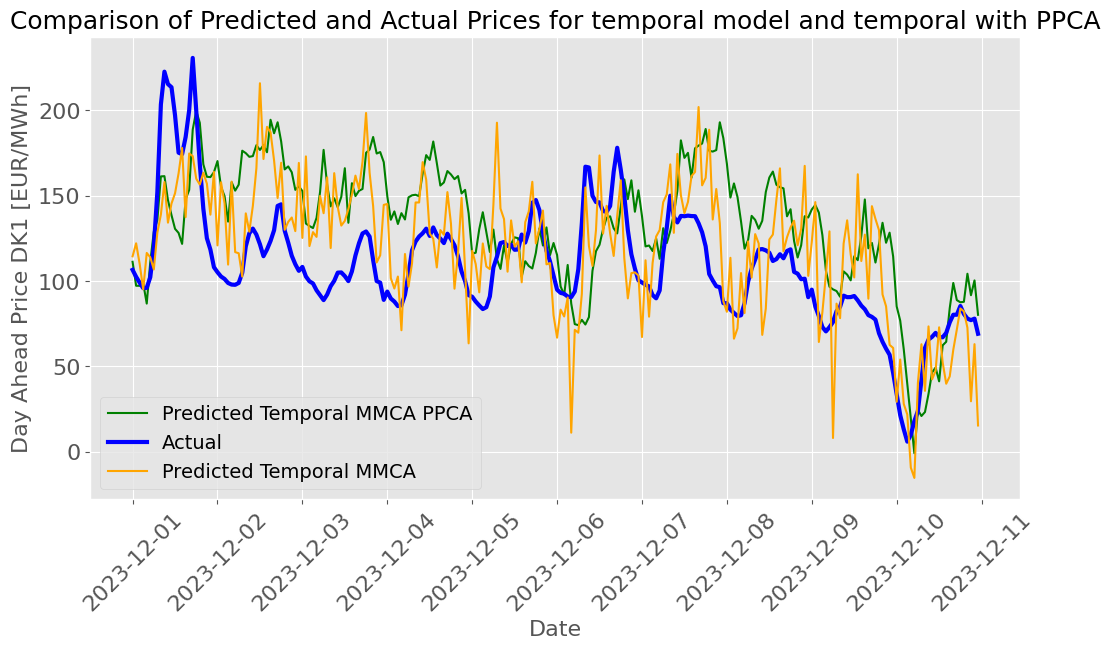

In [32]:

# Plot results of temporal model with PPCA and temporal model without PPCA
plt.figure(figsize=(12, 6))
plt.plot(y_test.index[:10*24], predictions_temporal_MMCA_PPCA[:10*24], label="Predicted Temporal MMCA PPCA", color="green")
plt.plot(y_test.index[:10*24], y_test_num_std[:10*24], label="Actual", color="blue", linewidth=3)
plt.plot(y_test.index[:10*24], predictions_temporal_MMCA[:10*24], label="Predicted Temporal MMCA", color="orange")  
plt.xlabel("Date", fontsize=16)
plt.ylabel("Day Ahead Price DK1 [EUR/MWh]", fontsize=16)
plt.xticks(fontsize=16, rotation=45)
plt.yticks(fontsize=16)
plt.title("Comparison of Predicted and Actual Prices for temporal model and temporal with PPCA", fontsize=18)
plt.legend(fontsize=14)
plt.savefig('plots/comparison_of_predicted_and_actual_prices_temporal_PPCA.png', bbox_inches='tight')
plt.show()